In [30]:
import os
import pandas as pd
import yaml
import torch
import collections

import warnings
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

warnings.filterwarnings("ignore")

In [31]:
def process_experiment(root_dir):
    rows = []

    for name in os.listdir(root_dir):
        experiment_path = os.path.join(root_dir, name)
        if os.path.isdir(experiment_path):
            for seed_name in os.listdir(experiment_path):
                seed_path = os.path.join(experiment_path, seed_name)
                if os.path.isdir(seed_path):
                    row_data = process_subexperiment(
                        seed_path, os.path.basename(root_dir)
                    )
                    for data in row_data:
                        data["seed"] = seed_name
                        data["experiment_name"] = name
                    rows.extend(row_data)  

    # Create a DataFrame from the rows
    df = pd.DataFrame(rows)
    return df


def process_subexperiment(seed_folder_path, experiment_name):
    cfg_data = read_config(os.path.join(seed_folder_path, "cfg.yaml"), experiment_name)
    train_stats_file = find_train_stats_file(seed_folder_path)
    if train_stats_file:
        experiment_results = process_training_stats(
            train_stats_file, cfg_data
        )
        return experiment_results
    else:
        return []  # Return an empty list if no train stats file is found


def read_config(cfg_path, experiment_name):
    with open(cfg_path, "r") as file:
        config = yaml.safe_load(file)
        full_title = config.get("full_title", "")
        variable_part = remove_experiment_name(full_title, experiment_name)
        return parse_config_variables(variable_part)


def remove_experiment_name(full_title, experiment_name):
    to_remove = experiment_name + "_"
    return (
        full_title[len(to_remove) :].strip()
        if full_title.startswith(to_remove)
        else full_title
    )


def parse_config_variables(variable_str):
    variables = {}
    for part in variable_str.split(";"):
        if "=" in part:
            key, value = part.split("=", 1)
            variables[key.strip()] = value.strip()
    return variables


def find_train_stats_file(folder_path):
    for file in os.listdir(folder_path):
        if file.endswith("_train_stats"):
            return os.path.join(folder_path, file)
    return None


def process_training_stats(train_stats_file, cfg_data):
    checkpoint = torch.load(train_stats_file)

    training_stats = checkpoint.get("training_stats", [])
    validation_stats = checkpoint.get("validation_stats", [])
    redo_stats = checkpoint.get("redo_scores", [])

    stats_records = process_stats(training_stats, cfg_data, "training") + process_stats(
        validation_stats, cfg_data, "validation"
    )

    # Combine stats records with redo scores
    combined_records = []
    for record in stats_records:
        combined_record = record.copy()  # Copy the stats record
        combined_records.append(combined_record)

    return combined_records


def process_stats(stats, cfg_data, stats_type):
    records = []
    for epoch_stats in stats:
        record = {"epoch_type": stats_type}
        record.update(flatten(epoch_stats))  # Flatten the epoch_stats if it's nested
        record.update(cfg_data)  # Add configuration data
        records.append(record)
    return records


def flatten(d, parent_key="", sep="_"):
    items = []
    for k, v in d.items():
        new_key = parent_key + sep + k if parent_key else k
        if isinstance(v, collections.abc.MutableMapping):
            items.extend(flatten(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))
    return dict(items)

In [32]:
experiment_sub_dir = "2025Mar14-002712_configs"
exp_path = os.path.join(r"D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dynamics\experiments\results", experiment_sub_dir)
df = process_experiment(
    exp_path
)
df.columns


Index(['epoch_type', 'frame_stamp', 'episode_rewards_min',
       'episode_rewards_max', 'episode_rewards_mean', 'episode_rewards_median',
       'episode_rewards_std', 'episode_discounted_rewards_min',
       'episode_discounted_rewards_max', 'episode_discounted_rewards_mean',
       'episode_discounted_rewards_median', 'episode_discounted_rewards_std',
       'episode_frames_min', 'episode_frames_max', 'episode_frames_mean',
       'episode_frames_median', 'episode_frames_std', 'episode_losses_min',
       'episode_losses_max', 'episode_losses_mean', 'episode_losses_median',
       'episode_losses_std', 'episode_max_qs_min', 'episode_max_qs_max',
       'episode_max_qs_mean', 'episode_max_qs_median', 'episode_max_qs_std',
       'policy_trained_times', 'target_trained_times', 'epoch_time',
       'optim.args_.eps', 'optim.args_.lr',
       'estimator.args_.lin_hidden_out_size', 'agent_params.args_.batch_size',
       'agent_params.args_.gamma', 'seed', 'experiment_name'],
      dtype

In [33]:
df

,epoch_type,frame_stamp,episode_rewards_min,episode_rewards_max,episode_rewards_mean,episode_rewards_median,episode_rewards_std,episode_discounted_rewards_min,episode_discounted_rewards_max,episode_discounted_rewards_mean,...,policy_trained_times,target_trained_times,epoch_time,optim.args_.eps,optim.args_.lr,estimator.args_.lin_hidden_out_size,agent_params.args_.batch_size,agent_params.args_.gamma,seed,experiment_name
0,training,200000,-128.258580,-47.176627,-92.437597,-95.650579,13.228657,-29.290135,-18.908140,-23.501863,...,48749.0,48.0,0 days 00:03:05.720517,1e-08,0.0001,32,32,0.9,0,0000_optim.args_.eps_1e-08__optim.args_.lr_0.0...
1,training,400000,-127.282041,-84.461169,-97.754560,-97.281612,5.491383,-28.067579,-21.710809,-23.567008,...,50000.0,48.0,0 days 00:03:11.869134,1e-08,0.0001,32,32,0.9,0,0000_optim.args_.eps_1e-08__optim.args_.lr_0.0...
2,training,600000,-124.306595,-83.819675,-96.883824,-96.215824,5.306931,-27.626361,-21.595309,-23.374037,...,50000.0,52.0,0 days 00:03:09.169152,1e-08,0.0001,32,32,0.9,0,0000_optim.args_.eps_1e-08__optim.args_.lr_0.0...
3,training,800000,-119.763814,-84.710708,-96.383981,-95.749343,4.846462,-27.511471,-21.580392,-23.240572,...,50000.0,48.0,0 days 00:03:10.405833,1e-08,0.0001,32,32,0.9,0,0000_optim.args_.eps_1e-08__optim.args_.lr_0.0...
4,training,1000000,-116.544894,-84.453211,-95.703440,-95.204201,4.535245,-27.269158,-21.584527,-23.067699,...,50000.0,52.0,0 days 00:03:11.254066,1e-08,0.0001,32,32,0.9,0,0000_optim.args_.eps_1e-08__optim.args_.lr_0.0...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2971,validation,200000,-7368.717348,-5077.726617,-6479.378639,-6735.535295,894.640312,-75.449730,-75.440064,-75.446905,...,NaN,NaN,0 days 00:01:44.971004,1e-06,0.0001,128,64,0.99,1,0031_optim.args_.eps_1e-06__optim.args_.lr_0.0...
2972,validation,400000,-82.975791,-80.523437,-80.548364,-80.523437,0.144408,-66.163089,-64.256307,-64.271089,...,NaN,NaN,0 days 00:01:27.714091,1e-06,0.0001,128,64,0.99,1,0031_optim.args_.eps_1e-06__optim.args_.lr_0.0...
2973,validation,600000,-83.631631,-82.193296,-82.295985,-82.283137,0.101029,-65.927737,-64.916812,-64.964630,...,NaN,NaN,0 days 00:01:27.060730,1e-06,0.0001,128,64,0.99,1,0031_optim.args_.eps_1e-06__optim.args_.lr_0.0...
2974,validation,800000,-82.210915,-80.732225,-80.920425,-80.901537,0.115246,-65.375097,-64.324134,-64.398191,...,NaN,NaN,0 days 00:01:26.890393,1e-06,0.0001,128,64,0.99,1,0031_optim.args_.eps_1e-06__optim.args_.lr_0.0...


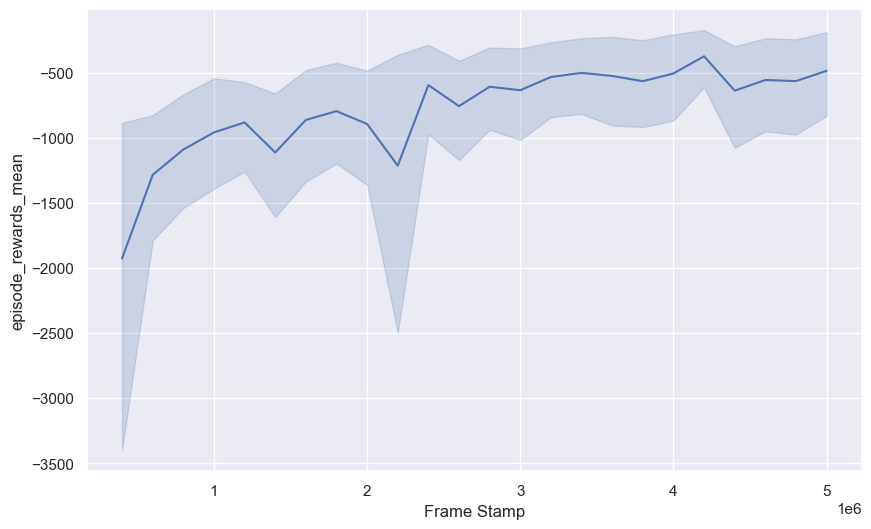

In [34]:
selected_metric = 'episode_rewards_mean'
# Filter for validation episodes
validation_df = df[df['epoch_type'] == 'validation']

# Get the unique sorted frame_stamp values
unique_frames = np.sort(validation_df['frame_stamp'].unique())
N = 1
# Get all frame_stamp values after the first N unique ones
filtered_frames = unique_frames[N:]

# Filter the DataFrame to only include rows with these frame_stamp values
filtered_df = validation_df[validation_df['frame_stamp'].isin(filtered_frames)]

plt.figure(figsize=(10, 6))
sns.lineplot(data=filtered_df, x='frame_stamp', y=selected_metric)
plt.ylabel(selected_metric)
plt.xlabel('Frame Stamp')
plt.show()

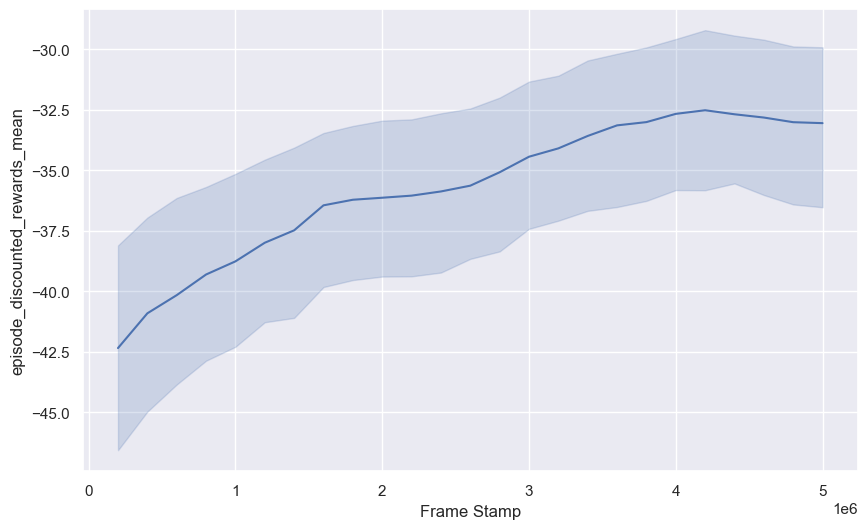

In [35]:

selected_metric = 'episode_discounted_rewards_mean'

validation_df = df[df['epoch_type'] == 'validation']


# Create a new figure for each environment
plt.figure(figsize=(10, 6))
# sns.lineplot(data=df, x='frame_stamp', y=selected_metric, hue='model')
sns.lineplot(data=df, x='frame_stamp', y=selected_metric)

plt.ylabel(selected_metric)
plt.xlabel('Frame Stamp')

# Place the legend outside the plot
# plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), title='Parameters')
plt.show()